In [1]:
import numpy as np
import matplotlib.pyplot as plt

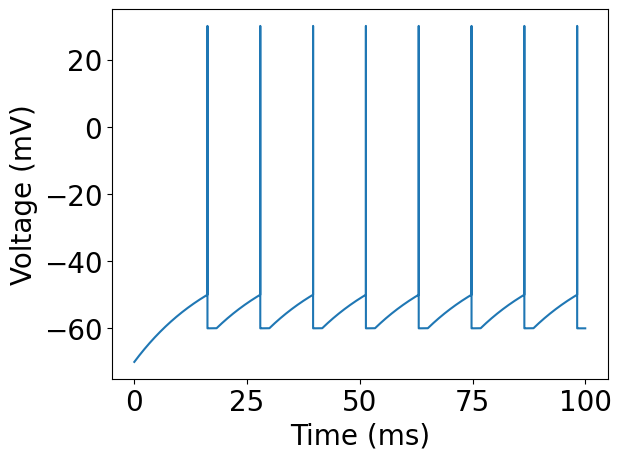

In [2]:
def calc_next_step(Vm, I, step_t, remaining_refrac_time):
    Vl = -70
    Gl = 0.025
    C = 0.5
    if Vm > -50 and Vm < 0: #threshold
        Vm = 30 #spike potential
    elif Vm > 0:
        Vm = -60 #reset potential
        remaining_refrac_time = remaining_refrac_time*0 + 2 #reset everything to 2
    elif remaining_refrac_time>0:
        Vm = -60 #reset potential
        remaining_refrac_time -= step_t
    else:
        Vm = Vm + step_t*(-Gl*(Vm-Vl) + I)/C
    if remaining_refrac_time<0:
        remaining_refrac_time = remaining_refrac_time*0
    return Vm,remaining_refrac_time

step_t = 0.001
t = np.arange(0,100+step_t,step_t)
Vm_out = np.zeros(np.shape(t)[0])
I = 0.9

ind = 0
Vm_out[0]=-70 #init state
remaining_refrac_time = 0
for tt in t[0:-1]:
    Vm_out[ind+1],remaining_refrac_time = calc_next_step(Vm_out[ind],I,step_t,remaining_refrac_time)
    ind += 1


plt.plot(t,Vm_out)
plt.xlabel("Time (ms)",fontsize = 20)
plt.ylabel("Voltage (mV)",fontsize = 20)
plt.tick_params(labelsize=20)
# plt.savefig("lif_1.png",bbox_inches = "tight")
plt.show()

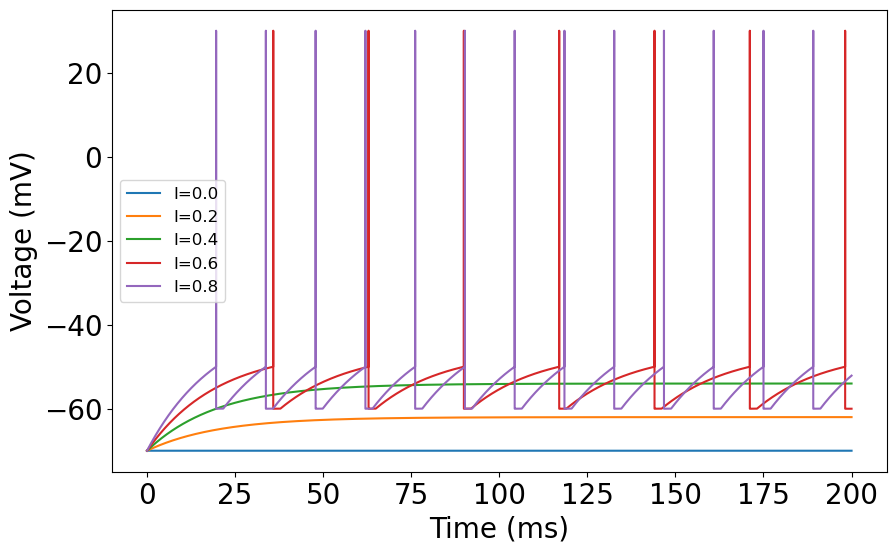

In [3]:
step_t = 0.001
t = np.arange(0,200+step_t,step_t)
I_ext = np.arange(0,1,0.2)

plt.figure(figsize=(10,6))
for i in range(5):
    Vm_out = np.zeros(np.shape(t)[0])
    I = I_ext[i]

    ind = 0
    Vm_out[0]=-70 #init state
    remaining_refrac_time = 0
    for tt in t[0:-1]:
        Vm_out[ind+1],remaining_refrac_time = calc_next_step(Vm_out[ind],I,step_t,remaining_refrac_time)
        ind += 1
    plt.plot(t,Vm_out,label='I={:.1f}'.format(I))

plt.xlabel("Time (ms)",fontsize = 20)
plt.ylabel("Voltage (mV)",fontsize = 20)
plt.tick_params(labelsize=20)
plt.legend(fontsize = 12)
# plt.savefig("lif_2.png",bbox_inches = "tight")
plt.show()

In [4]:
def calc_next_step_noise(Vm, I, step_t, remaining_refrac_time,sigma):
    Vl = -70
    Gl = 0.025
    C = 0.5
    wn = np.random.normal()
    if Vm > -50 and Vm < 0: #threshold
        Vm = 30 #spike potential
    elif Vm > 0:
        Vm = -60 #reset potential
        remaining_refrac_time = remaining_refrac_time*0 + 2 #reset everything to 2
    elif remaining_refrac_time>0:
        Vm = -60 #reset potential
        remaining_refrac_time -= step_t
    else:
        Vm = Vm + step_t*(-Gl*(Vm-Vl) + I)/C + sigma*np.sqrt(step_t)*wn
    if remaining_refrac_time<0:
        remaining_refrac_time = remaining_refrac_time*0
    return Vm,remaining_refrac_time

In the presence of noise, neurons that would not reach the threshold potential with the input current may also trigger an action potential.

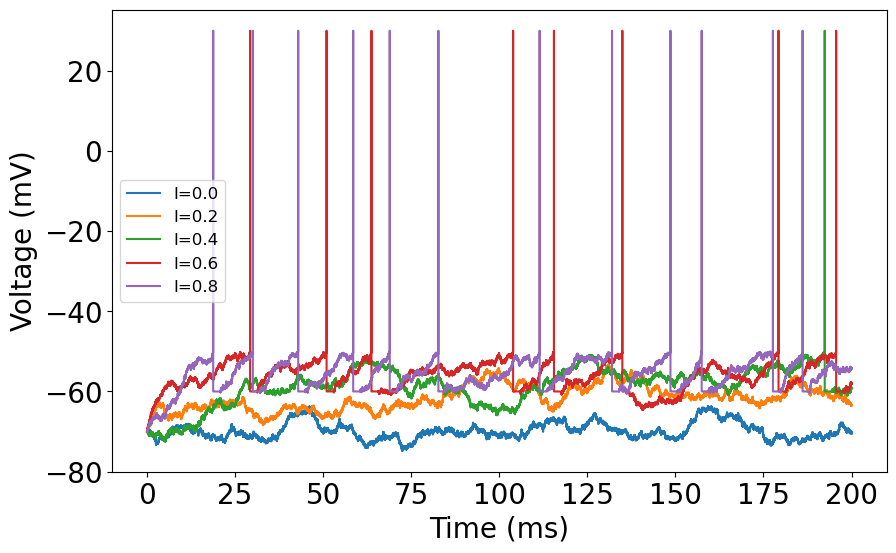

In [5]:
step_t = 0.001
t = np.arange(0,200+step_t,step_t)
I_ext = np.arange(0,1,0.2)

plt.figure(figsize=(10,6))
for i in range(5):
    Vm_out = np.zeros(np.shape(t)[0])
    I = I_ext[i]

    ind = 0
    Vm_out[0]=-70 #init state
    remaining_refrac_time = 0
    for tt in t[0:-1]:
        Vm_out[ind+1],remaining_refrac_time = calc_next_step_noise(Vm_out[ind],I,step_t,remaining_refrac_time,1)
        ind += 1
    plt.plot(t,Vm_out,label='I={:.1f}'.format(I))

plt.xlabel("Time (ms)",fontsize = 20)
plt.ylabel("Voltage (mV)",fontsize = 20)
plt.tick_params(labelsize=20)
plt.legend(fontsize = 12)
# plt.savefig("lif_3.png",bbox_inches = "tight")
plt.show()

In [6]:
def extract_CV_from_voltage(voltage,step_t):
    spike_cv = np.zeros(np.shape(voltage)[0]) 
    for ii in np.arange(0,np.shape(voltage)[0],1):
        idx_spike = np.transpose(np.argwhere(voltage[ii,:]==30))
        idx_spike_diff = np.diff(idx_spike)*step_t
        if len(idx_spike_diff[0]):
            mean_isi = np.mean(idx_spike_diff) #mean ISI
            std_isi = np.std(idx_spike_diff)
            spike_cv[ii] = std_isi/mean_isi
        else:
            spike_cv[ii] = 1
    return spike_cv

In [7]:
I_stim = np.linspace(0,1,200)
step_t = 0.001
t = np.arange(0,500+step_t,step_t)
firing_rate_list = []
firing_rate_noise_list = []

for i in range(200):
    Vm_out = np.zeros(np.shape(t)[0])
    I = I_stim[i]

    ind = 0
    Vm_out[0]=-70 #init state
    remaining_refrac_time = 0
    spike_num = 0
    for tt in t[0:-1]:
        # Vm_out[ind+1],remaining_refrac_time = calc_next_step_noise(Vm_out[ind],I,step_t,remaining_refrac_time,1)
        Vm_out[ind+1],remaining_refrac_time = calc_next_step(Vm_out[ind],I,step_t,remaining_refrac_time)
        if Vm_out[ind+1]== 30:
            spike_num += 1
        ind += 1
    firinf_rate = spike_num*1000/500
    firing_rate_list.append(spike_num)

for i in range(200):
    Vm_out = np.zeros(np.shape(t)[0])
    I = I_stim[i]

    ind = 0
    Vm_out[0]=-70 #init state
    remaining_refrac_time = 0
    spike_num = 0
    for tt in t[0:-1]:
        Vm_out[ind+1],remaining_refrac_time = calc_next_step_noise(Vm_out[ind],I,step_t,remaining_refrac_time,1)
        # Vm_out[ind+1],remaining_refrac_time = calc_next_step(Vm_out[ind],I,step_t,remaining_refrac_time)
        if Vm_out[ind+1]== 30:
            spike_num += 1
        ind += 1
    firinf_rate = spike_num*1000/500
    firing_rate_noise_list.append(spike_num)


Near the threshold, large fluctuations are prone to occur. As the voltage increases, the relative error will decrease.

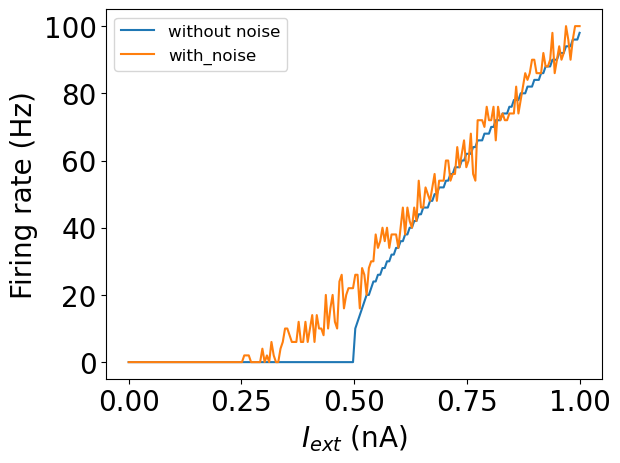

In [8]:

plt.plot(I_stim,np.array(firing_rate_list)*2,label='without noise')
plt.plot(I_stim,np.array(firing_rate_noise_list)*2,label ='with_noise')
plt.xlabel(r"$I_{ext}$ (nA)",fontsize = 20)
plt.ylabel("Firing rate (Hz)",fontsize = 20)
plt.tick_params(labelsize=20)
plt.legend(fontsize = 12)
# plt.savefig("lif_4.png",bbox_inches = "tight")
plt.show()

In [9]:
I_stim = np.linspace(0,1,50)
step_t = 0.001
t = np.arange(0,500+step_t,step_t)
cv_list = []
firing_rate_noise_list = []

for i in range(50):
    Vm_out = np.zeros(np.shape(t)[0])
    I = I_stim[i]
    ind = 0
    Vm_out[0]=-70 #init state
    remaining_refrac_time = 0
    spike_num = 0
    for tt in t[0:-1]:
        Vm_out[ind+1],remaining_refrac_time = calc_next_step_noise(Vm_out[ind],I,step_t,remaining_refrac_time,0.4)
        # Vm_out[ind+1],remaining_refrac_time = calc_next_step(Vm_out[ind],I,step_t,remaining_refrac_time)
        if Vm_out[ind+1]== 30:
            spike_num += 1
        ind += 1
    firinf_rate = spike_num*1000/500
    # print(Vm_out.flatten().shape)
    cv_list.append(extract_CV_from_voltage(Vm_out.reshape((1,-1)),step_t))
    firing_rate_noise_list.append(spike_num)


As the firing rate increases, the stability of the neuron's firing will gradually increase, and the CV (coefficient of variation) will gradually decrease.

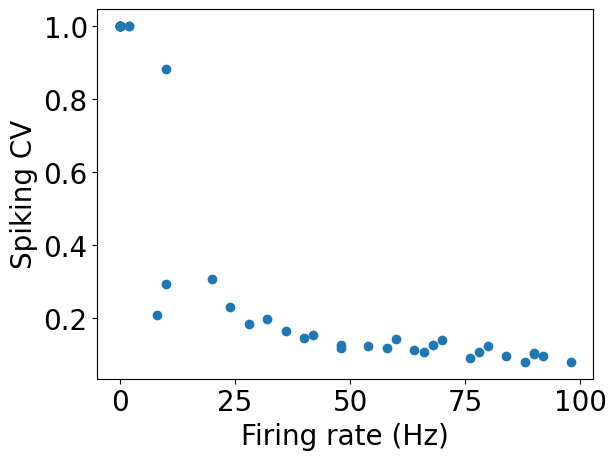

In [10]:
plt.plot(np.array(firing_rate_noise_list)*2,cv_list,'o')
plt.xlabel("Firing rate (Hz)",fontsize = 20)
plt.ylabel("Spiking CV",fontsize = 20)
plt.tick_params(labelsize=20)
# plt.savefig("lif_6.png",bbox_inches = "tight")
plt.show()